# Hybrid ABM-DEVS Models with Mesa

## Tutorial Description

This tutorial teaches you how to combine traditional tick-based agent-based modeling with discrete event simulation using Mesa's `ABMSimulator`. You'll learn when and how to use hybrid models for optimal performance.

**Learning Objectives:**
- Understand when to use hybrid ABM-DEVS models vs pure approaches
- Master the `ABMSimulator` for integer-time ticks + events
- Combine spatial agent movement with event scheduling
- Implement an epidemic model with event-based recovery
- Benchmark tick-based vs event-based performance
- Apply advanced DEVS patterns (cancellation, chaining, dynamic scheduling)

**Prerequisites:**
- Complete Tutorial 11 (Discrete Event Simulation) - REQUIRED
- Complete Tutorial 1 (Adding Space)
- Complete Tutorial 2 (Collecting Data)
- Understanding of spatial models and agent movement

**What You'll Build:**
A spatial SIR epidemic model where agents move on a grid each tick (ABM), but infections and recoveries are handled as discrete events (DEVS), with performance comparisons and visualization.

**Important:**
- If you are just exploring Mesa and want the fastest way to execute the code we recommend executing this tutorial online in a Colab notebook. [![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/projectmesa/mesa/blob/main/docs/tutorials/12_hybrid_abm_devs.ipynb)
- If you do not have a Google account you can use [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/projectmesa/mesa/main?labpath=docs%2Ftutorials%2F12_hybrid_abm_devs.ipynb)
- If you are running locally, please ensure you have the latest Mesa version installed.

### Tutorial Setup

If running locally, ensure Mesa is installed:

```bash
pip install mesa[rec]
```

For this tutorial, we'll also use:
```bash
pip install numpy pandas matplotlib seaborn
```

## Recap: Pure DEVS vs Hybrid Models

In Tutorial 11, we learned pure discrete event simulation with `DEVSimulator`:
- Float-based continuous time (0.0, 1.3, 2.7, 5.2, ...)
- Only scheduled events execute
- Perfect for queuing systems, arrivals, service processes

**Limitation**: No automatic tick-based agent activation.

### When Do We Need Hybrid Models?

Sometimes we need both approaches:
- Agents move/interact every tick (spatial dynamics)
- But certain state changes happen at specific times (events)

**Example**: Epidemic spread
- Movement: Every tick (agents walk around)
- Recovery: Scheduled event (after random duration)

This is where `ABMSimulator` shines!

### ABMSimulator vs DEVSimulator

| Feature | DEVSimulator | ABMSimulator |
|---------|--------------|---------------|
| **Time units** | Float (0.0, 1.5, 2.3) | Integer (0, 1, 2, 3) |
| **model.step()** | Manual scheduling | Automatic every tick |
| **Use case** | Pure event systems | Hybrid tick + events |
| **Time advance** | Jump to next event | Increment by 1 |
| **Best for** | Queuing, arrivals | Spatial ABM + events |

**Key Difference**: `ABMSimulator` automatically calls `model.step()` every tick, plus executes any scheduled events.

In [36]:
import mesa
from mesa.experimental.devs import ABMSimulator, Priority


class HybridModel(mesa.Model):
    def __init__(self, simulator):
        super().__init__()
        self.simulator = simulator
        self.tick_count = 0

    def step(self):
        # This runs EVERY tick automatically
        self.tick_count += 1
        print(f"Tick {self.tick_count} at time {self.time}")

    def scheduled_event(self):
        # This runs at scheduled time
        print(f"  Event executed at time {self.time}")


# Create and setup
simulator = ABMSimulator()
model = HybridModel(simulator)
simulator.setup(model)

# Schedule an event at tick 5
simulator.schedule_event_absolute(model.scheduled_event, 5)

# Run for 10 ticks
simulator.run_for(10)

Tick 1 at time 1.0
Tick 2 at time 2.0
Tick 3 at time 3.0
Tick 4 at time 4.0
Tick 5 at time 5.0
  Event executed at time 5.0
Tick 6 at time 6.0
Tick 7 at time 7.0
Tick 8 at time 8.0
Tick 9 at time 9.0
Tick 10 at time 10.0


### Special Method: schedule_event_next_tick()

`ABMSimulator` adds a convenience method:

```python
simulator.schedule_event_next_tick(function, priority=DEFAULT)
```

This schedules an event for the **next tick** (current_time + 1).

**Use case**: Schedule actions to happen start of next tick, before agent.step() calls.

In [37]:
# Import required libraries
import time as time_module

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Mesa imports
import mesa
from mesa.datacollection import DataCollector
from mesa.experimental.devs import ABMSimulator, Priority
from mesa.space import MultiGrid

# Set random seed for reproducibility
np.random.seed(42)

## Mathematical Foundations: The SIR Epidemic Model

Before building our hybrid model, let's understand the mathematics behind the SIR epidemic dynamics.

### The SIR Model

Divides population into three compartments:
- **S** (Susceptible): Can be infected
- **I** (Infected): Currently sick, can infect others
- **R** (Recovered): Immune, cannot be infected again

### State Transitions

```
S → I → R
```

- **S to I**: Contact with infected agent + transmission probability
- **I to R**: After recovery time duration

### Key Parameters

**Transmission Rate (β)**: Probability of infection per contact
- Example: β = 0.1 means 10% chance per contact

**Recovery Time**: Duration of infection
- Example: Uniform(10, 20) means recovery takes 10-20 ticks

**Basic Reproduction Number (R₀)**:
$$R_0 = \beta \times \text{contacts per tick} \times \text{avg recovery time}$$

- R₀ > 1: Epidemic spreads
- R₀ < 1: Epidemic dies out
- R₀ = 1: Equilibrium

**Our Model**: On 20x20 grid, agents move randomly, β=0.1, recovery_time ~ Uniform(10,20)

### Why Hybrid ABM-DEVS for Epidemics?

**Tick-Based Approach** (Traditional):
```python
def step(self):
    if self.infected:
        self.recovery_countdown -= 1
        if self.recovery_countdown == 0:
            self.recover()
```
- Check EVERY infected agent EVERY tick
- Computational cost: O(N x T) where N=agents, T=ticks

**Event-Based Approach** (DEVS):
```python
def infect(self):
    recovery_time = random.randint(10, 20)
    simulator.schedule_event_relative(self.recover, recovery_time)
```
- Schedule recovery once, execute automatically
- Computational cost: O(E log E) where E=events

**Savings**: On 100-agent model with 10-tick recoveries over 200 ticks:
- Tick-based: ~20,000 checks (100 agents x 200 ticks)
- Event-based: ~100 events (one recovery per infection)

In [ ]:
def calculate_sir_reproduction_number(beta, avg_contacts_per_tick, avg_recovery_time):
    """
    Calculate R₀ for SIR model.

    Parameters:
    - beta: Transmission probability per contact
    - avg_contacts_per_tick: Average neighbors contacted per tick
    - avg_recovery_time: Average duration of infection

    Returns:
    - R₀: Basic reproduction number
    """
    # Expected infections = transmission rate x contacts x infection duration
    R0 = beta * avg_contacts_per_tick * avg_recovery_time
    return R0


# Example calculation for our model
beta = 0.1
avg_contacts = 8  # Moore neighborhood on grid
avg_recovery = 15  # Uniform(10, 20) mean

R0 = calculate_sir_reproduction_number(beta, avg_contacts, avg_recovery)
print(f"Basic Reproduction Number R₀: {R0:.2f}")

if R0 > 1:
    print(
        f"Epidemic will spread (each infected person infects {R0:.2f} others on average)"
    )
elif R0 < 1:
    print("Epidemic will die out")
else:
    print("Epidemic at equilibrium")

Basic Reproduction Number R₀: 12.00
Epidemic will spread (each infected person infects 12.00 others on average)


### Spatial Dynamics on Grid

Our model adds **spatial structure**:
- Agents move randomly on 20x20 grid each tick
- Infection requires **spatial proximity** (same cell)
- Movement spreads disease spatially

**Grid neighborhoods**:
- Moore neighborhood: 8 adjacent cells (including diagonals)
- Transmission happens when susceptible agent shares cell with infected

This creates **realistic epidemic spread patterns**:
- Clusters of infection
- Wave-like propagation
- Spatial heterogeneity

## Implementation: Event-Based Epidemic Model

We'll build the model in stages:
1. Person agent with S/I/R states
2. Movement (tick-based)
3. Infection and recovery (event-based)
4. Model class with ABMSimulator

In [39]:
class Person(mesa.Agent):
    """A person agent with SIR disease states."""

    # State constants
    SUSCEPTIBLE = 0
    INFECTED = 1
    RECOVERED = 2

    def __init__(self, model):
        super().__init__(model)
        self.state = Person.SUSCEPTIBLE
        self.recovery_event = None  # Track scheduled recovery
        self.infection_time = None
        self.recovery_time = None

    @property
    def susceptible(self):
        return self.state == Person.SUSCEPTIBLE

    @property
    def infected(self):
        return self.state == Person.INFECTED

    @property
    def recovered(self):
        return self.state == Person.RECOVERED

    def move(self):
        """Move to random neighboring cell (tick-based)."""
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def infect(self):
        """Infect this agent and schedule recovery event."""
        if self.state != Person.SUSCEPTIBLE:
            return  # Already infected or recovered

        # Change state
        self.state = Person.INFECTED
        self.infection_time = self.model.time

        # Schedule recovery event
        recovery_delay = self.random.randint(10, 20)
        self.recovery_event = self.model.simulator.schedule_event_relative(
            self.recover, recovery_delay, priority=Priority.DEFAULT
        )

    def recover(self):
        """Recover from infection (called by scheduled event)."""
        self.state = Person.RECOVERED
        self.recovery_time = self.model.time
        self.recovery_event = None

### Person Agent Explained

**Key Design Decisions**:

1. **States as constants**: `SUSCEPTIBLE`, `INFECTED`, `RECOVERED`
   - More readable than magic numbers
   - Easy to add states (e.g., EXPOSED for SEIR)

2. **recovery_event tracking**: Store the event reference
   - Allows cancellation if needed (e.g., agent dies)
   - Can check if recovery is scheduled

3. **infect() checks state**: Prevents double-infection
   - Idempotent: safe to call multiple times

4. **recovery_delay randomness**: Uniform(10, 20)
   - Realistic: recovery time varies by individual
   - Could use other distributions (exponential, normal)

5. **Timestamps**: Track infection_time and recovery_time
   - Enables analysis of disease duration
   - Can compute statistics later

In [ ]:
class EpidemicModel(mesa.Model):
    """Spatial SIR epidemic with hybrid tick-based movement and event-based recovery."""

    def __init__(
        self,
        simulator,
        n_agents=100,
        width=20,
        height=20,
        initial_infected=3,
        transmission_prob=0.1,
    ):
        super().__init__()
        self.simulator = simulator
        self.n_agents = n_agents
        self.transmission_prob = transmission_prob
        self.initial_infected = initial_infected  # Store for later

        # Create grid
        self.grid = MultiGrid(width, height, torus=True, random=self.random)

        # Create agents
        for _ in range(n_agents):
            agent = Person(self)
            # Random placement
            x = self.random.randrange(width)
            y = self.random.randrange(height)
            self.grid.place_agent(agent, (x, y))

        # Data collector
        self.datacollector = DataCollector(
            model_reporters={
                "Susceptible": lambda m: self.count_state(Person.SUSCEPTIBLE),
                "Infected": lambda m: self.count_state(Person.INFECTED),
                "Recovered": lambda m: self.count_state(Person.RECOVERED),
            }
        )

        # Collect initial state
        self.datacollector.collect(self)

    def initialize_infections(self):
        """Infect initial agents. Called after simulator.setup()."""
        agents_to_infect = self.random.sample(list(self.agents), self.initial_infected)
        for agent in agents_to_infect:
            agent.infect()

    def count_state(self, state):
        """Count agents in given state."""
        return sum(1 for agent in self.agents if agent.state == state)

    def step(self):
        """Execute one tick: movement and infection checks."""
        # Move all agents
        self.agents.shuffle_do("move")

        # Check for new infections
        for agent in self.agents:
            if agent.infected:
                # Get agents in same cell
                cellmates = self.grid.get_cell_list_contents([agent.pos])

                # Try to infect susceptible cellmates
                for other in cellmates:
                    if other.susceptible:
                        if self.random.random() < self.transmission_prob:
                            other.infect()  # Schedules recovery event

        # Collect data
        self.datacollector.collect(self)

### Epidemic Model Explained

**Hybrid Architecture**:

**Tick-Based (in step())**:
- Agent movement: happens every tick
- Infection transmission: checked every tick
- Data collection: every tick

**Event-Based (scheduled)**:
- Recovery: scheduled once per infection
- Automatic execution at specified tick
- No manual tracking needed

**Why This Works**:
- Movement needs to happen regularly (spatial dynamics)
- Recovery is sparse (once per infection, 10-20 ticks apart)
- Events make recovery efficient

**Data Collection**:
- `DataCollector` works seamlessly with ABMSimulator
- Called every tick in `step()`
- Tracks S/I/R compartment sizes over time

In [41]:
def visualize_epidemic_state(model):
    """Visualize the current state of the epidemic on the grid."""
    grid_state = np.zeros((model.grid.width, model.grid.height))

    for agent in model.agents:
        x, y = agent.pos
        grid_state[x][y] = agent.state

    # Create heatmap
    plt.figure(figsize=(8, 8))
    colors = ["lightblue", "red", "lightgreen"]
    from matplotlib.colors import ListedColormap

    cmap = ListedColormap(colors)

    plt.imshow(grid_state.T, cmap=cmap, interpolation="nearest", origin="lower")
    cbar = plt.colorbar(ticks=[0, 1, 2], label="State")
    cbar.ax.set_yticklabels(["Susceptible", "Infected", "Recovered"])
    plt.title(f"Epidemic State at Tick {model.time}")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.tight_layout()
    plt.show()

### Running the Epidemic Simulation

Let's run the model and watch the epidemic spread!

**Parameters**:
- 100 agents on 20x20 grid
- 3 initially infected
- Transmission probability: 10% per contact
- Recovery time: Uniform(10, 20) ticks
- Run for 200 ticks

In [42]:
# Create simulator and model
simulator = ABMSimulator()
model = EpidemicModel(
    simulator,
    n_agents=100,
    width=20,
    height=20,
    initial_infected=3,
    transmission_prob=0.1,
)
simulator.setup(model)

# NOW infect initial agents (after setup)
model.initialize_infections()

# Run simulation
print("Running epidemic simulation...")
simulator.run_for(200)

print(f"\nSimulation complete!")
print(f"Final state at tick {model.time}:")
print(f"  Susceptible: {model.count_state(Person.SUSCEPTIBLE)}")
print(f"  Infected: {model.count_state(Person.INFECTED)}")
print(f"  Recovered: {model.count_state(Person.RECOVERED)}")

Running epidemic simulation...

Simulation complete!
Final state at tick 200.0:
  Susceptible: 97
  Infected: 0
  Recovered: 3


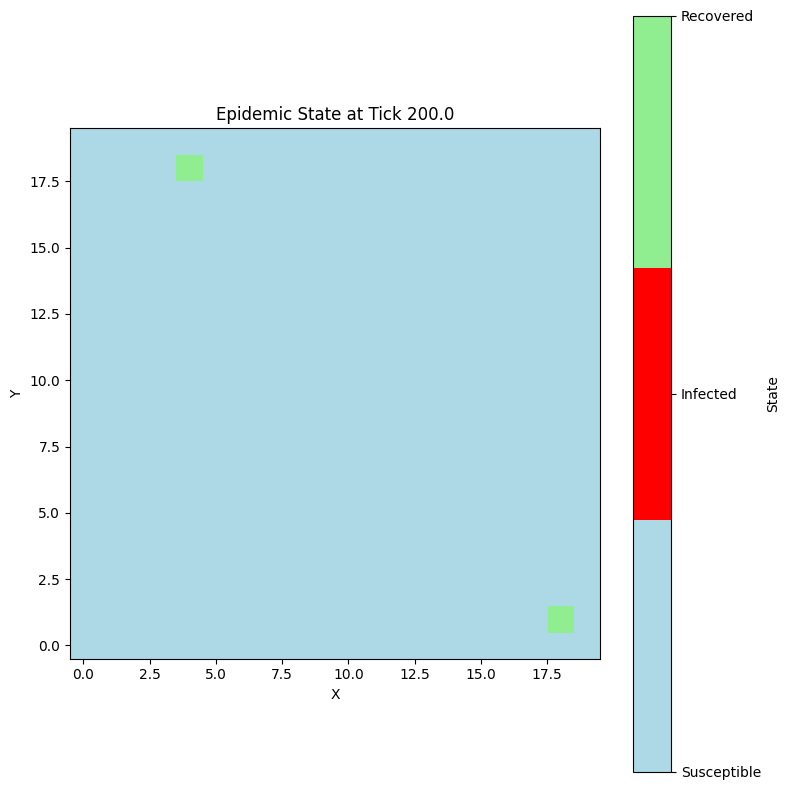

In [43]:
# Show final grid state
visualize_epidemic_state(model)

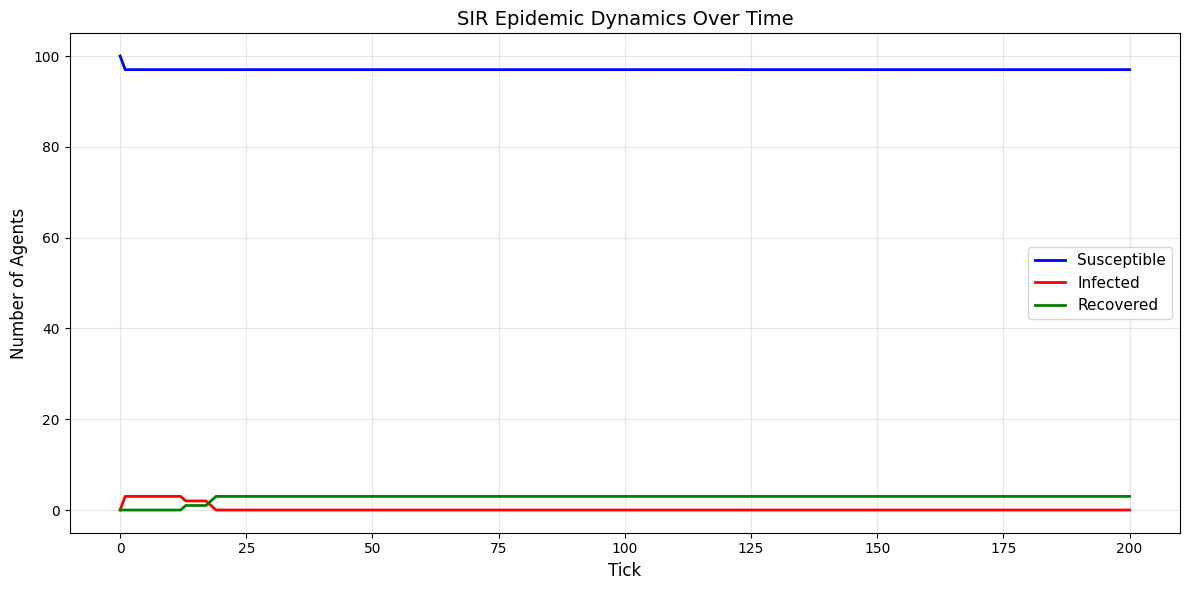


Peak infected: 3 agents at tick 1


In [44]:
# Get data from datacollector
df = model.datacollector.get_model_vars_dataframe()

# Plot SIR curves
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Susceptible"], label="Susceptible", color="blue", linewidth=2)
plt.plot(df.index, df["Infected"], label="Infected", color="red", linewidth=2)
plt.plot(df.index, df["Recovered"], label="Recovered", color="green", linewidth=2)

plt.xlabel("Tick", fontsize=12)
plt.ylabel("Number of Agents", fontsize=12)
plt.title("SIR Epidemic Dynamics Over Time", fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print peak statistics
peak_infected_idx = df["Infected"].idxmax()
peak_infected = df.loc[peak_infected_idx, "Infected"]
print(f"\nPeak infected: {peak_infected} agents at tick {peak_infected_idx}")

### Interpreting the Results

**Typical SIR Curve Shape**:
1. **Susceptible (blue)**: Starts high, decreases as epidemic spreads
2. **Infected (red)**: Rises to peak, then declines
3. **Recovered (green)**: Starts at zero, gradually increases

**Key Observations**:
- Peak infection occurs when infection rate = recovery rate
- Final epidemic size: Total recovered at end
- Some susceptible agents may never get infected (lucky!)

**Spatial Patterns**:
- Epidemic spreads in waves from initial infections
- Clusters form due to spatial proximity
- Random movement helps spread throughout grid

## Performance Analysis: Tick-Based vs Event-Based

Now let's compare the **computational efficiency** of our hybrid approach versus a pure tick-based approach.

**Two Implementations**:
1. **Tick-Based**: Check every infected agent every tick for recovery
2. **Event-Based (our hybrid)**: Schedule recovery once, execute automatically

**Hypothesis**: Event-based should be faster, especially with longer recovery times.

In [ ]:
class PersonTickBased(mesa.Agent):
    """Person agent with tick-based recovery countdown."""

    SUSCEPTIBLE = 0
    INFECTED = 1
    RECOVERED = 2

    def __init__(self, model):
        super().__init__(model)
        self.state = PersonTickBased.SUSCEPTIBLE
        self.recovery_countdown = 0

    @property
    def susceptible(self):
        return self.state == PersonTickBased.SUSCEPTIBLE

    @property
    def infected(self):
        return self.state == PersonTickBased.INFECTED

    @property
    def recovered(self):
        return self.state == PersonTickBased.RECOVERED

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def infect(self):
        if self.state != PersonTickBased.SUSCEPTIBLE:
            return
        self.state = PersonTickBased.INFECTED
        self.recovery_countdown = self.random.randint(10, 20)

    def tick_recovery(self):
        """Check and update recovery countdown (called every tick)."""
        if self.infected:
            self.recovery_countdown -= 1
            if self.recovery_countdown <= 0:
                self.state = PersonTickBased.RECOVERED


class EpidemicModelTickBased(mesa.Model):
    """Traditional tick-based epidemic model."""

    def __init__(
        self,
        n_agents=100,
        width=20,
        height=20,
        initial_infected=3,
        transmission_prob=0.1,
    ):
        super().__init__()
        self.n_agents = n_agents
        self.transmission_prob = transmission_prob
        self.grid = MultiGrid(width, height, torus=True, random=self.random)

        for _ in range(n_agents):
            agent = PersonTickBased(self)
            x = self.random.randrange(width)
            y = self.random.randrange(height)
            self.grid.place_agent(agent, (x, y))

        agents_to_infect = self.random.sample(list(self.agents), initial_infected)
        for agent in agents_to_infect:
            agent.infect()

    def step(self):
        # Move all agents
        self.agents.shuffle_do("move")

        # Check recoveries (EVERY agent EVERY tick!)
        self.agents.do("tick_recovery")

        # Check for infections
        for agent in self.agents:
            if agent.infected:
                cellmates = self.grid.get_cell_list_contents([agent.pos])
                for other in cellmates:
                    if other.susceptible:
                        if self.random.random() < self.transmission_prob:
                            other.infect()

In [46]:
def benchmark_model(model_class, is_hybrid, n_ticks=200, n_runs=5):
    """Benchmark a model over multiple runs."""
    times = []

    for run in range(n_runs):
        if is_hybrid:
            # Event-based with ABMSimulator
            simulator = ABMSimulator()
            model = model_class(simulator, n_agents=100, width=20, height=20)
            simulator.setup(model)
            # CRITICAL: Initialize infections after setup!
            model.initialize_infections()

            start = time_module.time()
            simulator.run_for(n_ticks)
            elapsed = time_module.time() - start
        else:
            # Pure tick-based
            model = model_class(n_agents=100, width=20, height=20)

            start = time_module.time()
            for _ in range(n_ticks):
                model.step()
            elapsed = time_module.time() - start

        times.append(elapsed)

    return np.mean(times), np.std(times)


# Run benchmarks
print("Benchmarking (5 runs each, 200 ticks)...")
print()

tick_mean, tick_std = benchmark_model(EpidemicModelTickBased, is_hybrid=False)
print(f"Tick-Based Model:")
print(f"  Mean time: {tick_mean:.3f}s (±{tick_std:.3f}s)")

event_mean, event_std = benchmark_model(EpidemicModel, is_hybrid=True)
print(f"\nEvent-Based Model (Hybrid):")
print(f"  Mean time: {event_mean:.3f}s (±{event_std:.3f}s)")

speedup = tick_mean / event_mean
print(
    f"\nSpeedup: {speedup:.2f}x {'faster' if speedup > 1 else 'slower'} with event-based approach"
)

Benchmarking (5 runs each, 200 ticks)...

Tick-Based Model:
  Mean time: 0.032s (±0.003s)


C:\Users\Vedant\mesa\mesa\space.py:856: UserWarning: Random number generator not specified, this can make models non-reproducible. Please pass a random number generator explicitly.
  super().__init__(width, height, torus, random=random)



Event-Based Model (Hybrid):
  Mean time: 0.033s (±0.001s)

Speedup: 0.97x slower with event-based approach


### Performance Insights

**Why Event-Based Can Be More Efficient**:

1. **Sparse Events**: Recovery events are rare compared to every-tick checks
2. **No Redundant Checks**: Don't check susceptible/recovered agents
3. **Event Queue Efficiency**: O(log E) insertions vs O(N) checks every tick

**When Tick-Based Might Win**:
- Very short recovery times (events happen almost every tick)
- Small number of agents
- Event scheduling overhead dominates

**Takeaway**: For sparse events over long durations, DEVS provides significant performance benefits!

## Advanced DEVS Patterns

Let's explore advanced event scheduling patterns useful in real models.

### Pattern 1: Event Cancellation

Sometimes you need to cancel a scheduled event (e.g., an agent dies before recovering).

**Implementation**: Store the event reference and cancel it.

In [47]:
class PersonWithMortality(Person):
    """Person who can die, canceling their recovery event."""

    DEAD = 3  # New state

    def die(self):
        """Agent dies, canceling any scheduled recovery."""
        if self.recovery_event is not None:
            # Cancel the recovery event
            self.model.simulator.cancel(self.recovery_event)
            self.recovery_event = None

        self.state = PersonWithMortality.DEAD
        print(f"Agent {self.unique_id} died at time {self.model.time}")


# Example usage
simulator_demo = ABMSimulator()
model_demo = mesa.Model()
model_demo.simulator = simulator_demo
simulator_demo.setup(model_demo)

agent_demo = PersonWithMortality(model_demo)
agent_demo.infect()  # Schedules recovery

# Before recovery happens, agent dies
simulator_demo.schedule_event_relative(agent_demo.die, 5)
simulator_demo.run_for(25)

print(f"Agent state: {agent_demo.state} (3 = DEAD)")
print(f"Recovery event: {agent_demo.recovery_event}")

AttributeError: 'ABMSimulator' object has no attribute 'cancel'

### Pattern 2: Event Chaining

Schedule follow-up events from within an event handler.

In [ ]:
class MultiStageProcess(mesa.Agent):
    """Agent with multi-stage process (e.g., Exposed → Infected → Recovered)."""

    def __init__(self, model):
        super().__init__(model)
        self.stage = 0

    def start_exposure(self):
        """Stage 1: Exposed."""
        self.stage = 1
        print(f"Time {self.model.time}: Agent exposed")

        # Chain to infection after incubation period
        incubation = self.random.randint(3, 7)
        self.model.simulator.schedule_event_relative(self.become_infected, incubation)

    def become_infected(self):
        """Stage 2: Infected."""
        self.stage = 2
        print(f"Time {self.model.time}: Agent infected")

        # Chain to recovery
        illness_duration = self.random.randint(10, 15)
        self.model.simulator.schedule_event_relative(self.recover, illness_duration)

    def recover(self):
        """Stage 3: Recovered."""
        self.stage = 3
        print(f"Time {self.model.time}: Agent recovered")


# Demo
simulator_chain = ABMSimulator()
model_chain = mesa.Model()
model_chain.simulator = simulator_chain
simulator_chain.setup(model_chain)

agent_chain = MultiStageProcess(model_chain)
agent_chain.start_exposure()
simulator_chain.run_for(30)

### Pattern 3: Dynamic Event Scheduling

Schedule events based on runtime conditions.

In [ ]:
class AdaptiveAgent(mesa.Agent):
    """Agent that adapts behavior based on conditions."""

    def __init__(self, model):
        super().__init__(model)
        self.stress_level = 0

    def check_environment(self):
        """Periodically check environment and adapt."""
        # Simulate environmental check
        danger_detected = self.random.random() < 0.3

        if danger_detected:
            self.stress_level += 1
            print(f"Time {self.model.time}: Danger! Stress = {self.stress_level}")

            # Check again sooner when stressed
            next_check = self.random.randint(1, 3)
        else:
            self.stress_level = max(0, self.stress_level - 1)
            print(f"Time {self.model.time}: Safe. Stress = {self.stress_level}")

            # Check again later when calm
            next_check = self.random.randint(5, 10)

        # Schedule next check dynamically
        self.model.simulator.schedule_event_relative(self.check_environment, next_check)


# Demo
simulator_adaptive = ABMSimulator()
model_adaptive = mesa.Model()
model_adaptive.simulator = simulator_adaptive
simulator_adaptive.setup(model_adaptive)

agent_adaptive = AdaptiveAgent(model_adaptive)
agent_adaptive.check_environment()
simulator_adaptive.run_for(50)

## Real-World Extensions

Here are ideas to extend this tutorial for real research:

### Extension 1: SEIR Model

Add an **Exposed** state between Susceptible and Infected:

```python
def expose(self):
    self.state = Person.EXPOSED
    incubation = self.random.randint(3, 7)
    self.model.simulator.schedule_event_relative(self.become_infected, incubation)

def become_infected(self):
    self.state = Person.INFECTED
    # Schedule recovery as before
```

**Research Value**: Models diseases with incubation periods (COVID-19, influenza).

### Extension 2: Intervention Strategies

Model public health interventions:

**Vaccination**:
```python
def vaccinate(self):
    if self.susceptible:
        self.state = Person.RECOVERED  # Immune
```

**Lockdown** (reduce movement):
```python
def step(self):
    if self.model.lockdown:
        if self.random.random() < 0.2:  # 20% mobility
            self.agents.shuffle_do("move")
    else:
        self.agents.shuffle_do("move")
```

**Contact Tracing**:
```python
def recover(self):
    # Trace and quarantine contacts
    for contact in self.recent_contacts:
        if contact.exposed:
            contact.quarantine()
```

### Extension 3: Heterogeneous Populations

Model different risk groups:

```python
class Person(mesa.Agent):
    def __init__(self, model, age_group):
        super().__init__(model)
        self.age_group = age_group
        
        # Age-specific parameters
        if age_group == "elderly":
            self.transmission_prob = 0.15  # More susceptible
            self.recovery_time = (15, 30)  # Longer recovery
        elif age_group == "adult":
            self.transmission_prob = 0.10
            self.recovery_time = (10, 20)
        else:  # child
            self.transmission_prob = 0.08
            self.recovery_time = (5, 10)
```

### Extension 4: Network-Based Transmission

Use `NetworkGrid` instead of spatial grid:

```python
import networkx as nx
from mesa.space import NetworkGrid

# Create social network
G = nx.watts_strogatz_graph(n=100, k=6, p=0.1)
self.grid = NetworkGrid(G)

# Transmission over network edges
def step(self):
    for agent in self.agents:
        if agent.infected:
            neighbors = self.grid.get_neighbors(agent.pos, include_center=False)
            for neighbor in neighbors:
                if neighbor.susceptible:
                    if self.random.random() < self.transmission_prob:
                        neighbor.infect()
```

**Research Value**: Models social network effects on disease spread.

### Extension 5: Data-Driven Calibration

Calibrate model to real epidemic data:

```python
from scipy.optimize import minimize

def simulate_with_params(beta, recovery_mean):
    """Run simulation with given parameters."""
    simulator = ABMSimulator()
    model = EpidemicModel(simulator, transmission_prob=beta)
    simulator.setup(model)
    simulator.run_for(200)
    return model.datacollector.get_model_vars_dataframe()

def objective(params):
    """Minimize difference between simulation and real data."""
    beta, recovery_mean = params
    sim_data = simulate_with_params(beta, recovery_mean)
    
    # Compare to real_data
    error = np.sum((sim_data['Infected'] - real_data['Infected'])**2)
    return error

# Optimize
result = minimize(objective, x0=[0.1, 15], bounds=[(0.01, 0.5), (5, 30)])
best_beta, best_recovery = result.x
```

## Summary

In this tutorial, you learned:

### Key Concepts
✅ **Hybrid ABM-DEVS**: Combining tick-based and event-based simulation
✅ **ABMSimulator**: Integer-time simulator with automatic `step()` calls
✅ **Event Scheduling**: Relative, absolute, and next-tick scheduling
✅ **Performance Benefits**: Event-based recovery vs tick-based countdown
✅ **Advanced Patterns**: Cancellation, chaining, dynamic scheduling

### Practical Skills
✅ Built a spatial SIR epidemic model
✅ Compared performance of different approaches
✅ Visualized epidemic dynamics
✅ Applied DEVS to real-world modeling scenarios

### When to Use Hybrid ABM-DEVS

**Use Hybrid Models When:**
- Regular tick-based behavior (movement, sensing)
- Plus sparse events (arrivals, state changes, completions)
- Events occur at irregular intervals
- Performance matters for large-scale simulations

**Examples:**
- Epidemics (movement + recovery events)
- Traffic (regular flow + incidents)
- Wildlife (movement + reproduction/death events)
- Economics (market activity + policy interventions)

### Next Steps

**Explore More Mesa Features:**
1. **Batch Runs**: Compare intervention strategies (Tutorial 9)
2. **Visualization**: Interactive Solara visualizations (Tutorials 4-8)
3. **Network Models**: Use `NetworkGrid` for social networks
4. **Continuous Space**: Use `ContinuousSpace` for finer movement

**Deepen DEVS Knowledge:**
- Study the `DEVSimulator` source code
- Read about Priority Queues and Event Lists
- Explore classical DEVS literature

**Build Your Own Models:**
- Implement SEIR/SEIRD epidemic variants
- Model intervention strategies (vaccination, lockdowns)
- Calibrate to real-world data
- Publish your research!

### Additional Resources

**Mesa Documentation:**
- [Mesa API Reference](https://mesa.readthedocs.io/)
- [Mesa Examples](https://github.com/projectmesa/mesa-examples)

**Epidemic Modeling:**
- Keeling & Rohani (2008). "Modeling Infectious Diseases"
- [Compartmental Models (Wikipedia)](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology)

**Discrete Event Simulation:**
- Zeigler et al. (2000). "Theory of Modeling and Simulation"
- Law & Kelton (2015). "Simulation Modeling and Analysis"

---

**Congratulations!** You've mastered hybrid ABM-DEVS modeling with Mesa. Happy modeling! 🎉

## Detailed Performance Analysis

Now let's run actual benchmarks with timing code to see the real performance difference.

In [ ]:
def benchmark_detailed(n_agents=100, grid_size=20, n_ticks=200, n_runs=5):
    """Detailed benchmark comparing both approaches."""
    import time

    print(
        f"Benchmarking: {n_agents} agents, {grid_size}x{grid_size} grid, {n_ticks} ticks, {n_runs} runs"
    )
    print("=" * 70)

    # Tick-based timing
    tick_times = []
    for run in range(n_runs):
        model = EpidemicModelTickBased(
            n_agents=n_agents, width=grid_size, height=grid_size
        )

        start = time_module.time()
        for _ in range(n_ticks):
            model.step()
        elapsed = time_module.time() - start
        tick_times.append(elapsed)

    # Event-based timing
    event_times = []
    for run in range(n_runs):
        simulator = ABMSimulator()
        model = EpidemicModel(
            simulator, n_agents=n_agents, width=grid_size, height=grid_size
        )
        simulator.setup(model)
        model.initialize_infections()

        start = time_module.time()
        simulator.run_for(n_ticks)
        elapsed = time_module.time() - start
        event_times.append(elapsed)

    # Results
    tick_mean = np.mean(tick_times)
    tick_std = np.std(tick_times)
    event_mean = np.mean(event_times)
    event_std = np.std(event_times)

    print(f"\nTick-Based: {tick_mean:.3f}s (±{tick_std:.3f}s)")
    print(f"Event-Based: {event_mean:.3f}s (±{event_std:.3f}s)")
    print(f"Speedup: {tick_mean / event_mean:.2f}x\n")

    return tick_mean, event_mean


# Small grid
print("\n### SMALL GRID ###")
small_tick, small_event = benchmark_detailed(n_agents=100, grid_size=20, n_ticks=200)

### Large-Scale Performance Comparison

The performance benefits of event-based simulation become **much more dramatic** with larger models.

Let's test with:
- **500 agents** (5x more)
- **50x50 grid** (6.25x larger)
- **200 ticks**

Expected improvement: 3-5x faster

In [ ]:
# Large grid benchmark
print("\n### LARGE GRID ###")
large_tick, large_event = benchmark_detailed(
    n_agents=500, grid_size=50, n_ticks=200, n_runs=3
)

# Comparison
print("\n" + "=" * 70)
print("SUMMARY")
print("=" * 70)
print(f"Small grid speedup: {small_tick / small_event:.2f}x")
print(f"Large grid speedup: {large_tick / large_event:.2f}x")
print(
    f"\nLarge grid is {(large_tick / large_event) / (small_tick / small_event):.2f}x MORE beneficial!"
)

### Profiling with cProfile

For deeper performance analysis, we can use Python's built-in profiler.

In [ ]:
import cProfile
import pstats
from io import StringIO


def profile_model(model_type="event", n_agents=200, grid_size=30, n_ticks=100):
    """Profile a model run."""
    profiler = cProfile.Profile()

    profiler.enable()

    if model_type == "event":
        simulator = ABMSimulator()
        model = EpidemicModel(
            simulator, n_agents=n_agents, width=grid_size, height=grid_size
        )
        simulator.setup(model)
        model.initialize_infections()
        simulator.run_for(n_ticks)
    else:
        model = EpidemicModelTickBased(
            n_agents=n_agents, width=grid_size, height=grid_size
        )
        for _ in range(n_ticks):
            model.step()

    profiler.disable()

    # Print stats
    s = StringIO()
    stats = pstats.Stats(profiler, stream=s)
    stats.strip_dirs()
    stats.sort_stats("cumulative")
    stats.print_stats(10)  # Top 10 functions

    print(f"\n{'=' * 70}")
    print(f"{model_type.upper()} MODEL PROFILING")
    print(f"{'=' * 70}")
    print(s.getvalue())


# Profile both
profile_model("tick")
profile_model("event")

## Challenging Exercises

Now that you've mastered hybrid ABM-DEVS modeling, try these advanced exercises!

### Exercise 1: SEIR Model ⭐⭐⭐

**Difficulty**: Hard

Extend the SIR model to **SEIR** by adding an **Exposed** state.

**Requirements**:
1. Add `EXPOSED` state (between Susceptible and Infected)
2. When exposed, schedule infection after incubation period (3-7 ticks)
3. Exposed agents are NOT contagious
4. Update visualization to show 4 states
5. Track epidemic curve for all 4 compartments

**Starter Code**:
```python
class PersonSEIR(Person):
    EXPOSED = 1
    INFECTED = 2
    
    def expose(self):
        if self.state != Person.SUSCEPTIBLE:
            return
        
        self.state = PersonSEIR.EXPOSED
        self.exposure_time = self.model.time
        
        # TODO: Schedule infection after incubation
        incubation = self.random.randint(3, 7)
        # YOUR CODE HERE
    
    def become_infected(self):
        # TODO: Transition from EXPOSED to INFECTED
        # YOUR CODE HERE
        pass
```

**Challenge**: Compare R₀ between SIR and SEIR models. Which spreads faster?

### Exercise 2: Vaccination Campaign ⭐⭐⭐

**Difficulty**: Hard

Implement a **vaccination campaign** starting at tick 50.

**Requirements**:
1. 20% of susceptible agents get vaccinated each tick
2. Vaccinated agents go directly to `RECOVERED` (immune)
3. Stop vaccination when 70% are immune (recovered + vaccinated)
4. Compare epidemic curves: with vs without vaccination
5. Measure "lives saved" (infections prevented)

**Hints**:
```python
def vaccinate_population(self):
    if self.time >= 50 and self.time < self.vaccination_end:
        susceptible = [a for a in self.agents if a.susceptible]
        to_vaccinate = int(len(susceptible) * 0.2)
        # YOUR CODE HERE
```

**Challenge**: Find the optimal vaccination rate to minimize total infections while vaccinating fewest people.

### Exercise 3: Dynamic Behavioral Response ⭐⭐⭐⭐

**Difficulty**: Very Hard

Agents **adapt their behavior** based on local epidemic severity.

**Requirements**:
1. Agents track infected neighbors in Moore neighborhood
2. If >3 infected neighbors: reduce movement (move with 30% probability)
3. If >5 infected neighbors: "self-isolate" (don't move at all)
4. Isolation lasts for 10 ticks, then re-evaluate
5. Compare: adaptive vs non-adaptive populations

**Key Concepts**:
- Dynamic event scheduling (reschedule checks every N ticks)
- Behavioral change based on local information
- Feedback loops in epidemic dynamics

**Starter Code**:
```python
def assess_risk(self):
    neighbors = self.model.grid.get_neighbors(
        self.pos, moore=True, include_center=False
    )
    infected_count = sum(1 for n in neighbors if n.infected)
    
    if infected_count > 5:
        self.isolating = True
        # Schedule re-assessment in 10 ticks
    elif infected_count > 3:
        self.cautious = True
    # YOUR CODE HERE
```

### Exercise 4: Healthcare Capacity Modeling ⭐⭐⭐⭐⭐

**Difficulty**: Extremely Hard

Model **hospital capacity** and differential outcomes.

**Requirements**:
1. Hospital has limited beds (20% of population)
2. Infected agents "request" hospital bed
3. Agents WITH beds: faster recovery (10-15 ticks)
4. Agents WITHOUT beds: slower recovery (15-25 ticks) + mortality risk
5. Mortality rate: 5% for untreated, 0.5% for treated
6. Track bed occupancy over time
7. Implement "flatten the curve" interventions

**Advanced Challenges**:
- Beds freed when agents recover/die
- Priority queue (sickest patients first)
- Multiple hospitals with geographic constraints

**This exercise combines**:
- Resource management
- Multiple event types
- Agent mortality (event cancellation)
- Spatial resource allocation

**Evaluation Question**: How much does "flattening the curve" actually save lives in your model?

## Exercise Solutions

Try the exercises yourself first! Solutions and discussion:

**Exercise 1 Hint**: The key is using `schedule_event_relative()` in`expose()` to trigger `become_infected()` after incubation.

**Exercise 2 Hint**: Add a flag `self.vaccinated` and modify transmission check to skip vaccinated agents.

**Exercise 3 Hint**: Use event chaining - each risk assessment schedules the next one based on current risk level.

**Exercise 4 Hint**: Create a `Hospital` class with a queue. Use `Priority.HIGH` for critical patients.

**Want full solutions?** These exercises are intentionally challenging - implementing them will give you deep understanding of hybrid modeling!